# Sentiment Analysis on Food reviews
# Part 2

## Executive Summary

#### Classical Machine Learning
Count Vectorizer and TF-IDF Vectorizer are methods for converting text data into vectors via Bag of Words (BoW) and N-gram encoding. Count Vectorizer uses frequency of words in the corpus. While TF-IDF take into account the importance of words in a document compared to other documents. Words showing up more often one document and not in other documents have more weightage.

Gridsearching will be done together with vectorizing and fitting machine learning model (Logistic Regression, Naive Bayes and Linear Support Vector Classifier) on the training data to obtain the best hyperparameters followed by evaluating on the models' performance on the validation dataset.

#### Deep learning
We will use Recurrent Neural Network (RNN) as our deep learning model as it is suitable for Sequence Data, like text. In order to learn long-term dependencies, Long Short-Term Memory (LSTM) would be use. This is to ensure that a word at the beginning of the sentence could be remembered by a word at far end of the sentence.


#### Evaluations
Comparing classical machine learning and deep learning for sentiment analysis, the best model would be chosen based on accuracy and recall on the validation set.

Deep learning outperformed all classical machine learning models and therefore is the best model in classifying sentiment of customers.

Topics that customers were dissatisfied about - Instant coffee and tea, bottled drinks, ingredient quality, pricey products, sugary snacks and pet food. Manufacturers could focus on improving their products, focuses on qualities that customers are concerned about and offering discounts to low quality products.

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|merge_processed|object|train/test|pre-processed summary and text of reviews for machine learning| 
|merge|object|train/test|raw summary and text of reviews| 
|score|int|train/test|review ratings (1 to 5)| 
|label|int|train/test/reviews|sentiment labels (1: negative) (0: positive)| 
|merge_dl|object|reviews|pre-processed summary and text of reviews for deep learning| 

## Contents
- [Import libraries](#Import-libraries)
- [Read in dataset](#Read-in-dataset)
- [Logistic regression](#Modeling)
- [Multinomial naive-bayes](#Multinomial-naive-bayes)
- [Linear support vector classifer](#Linear-support-vector-classifer)
- [Recurrent neural network](#Recurrent-neural-network)
- [Model evaluation](#Model-evaluation)
- [Predictive words for machine learning](#Predictive-words-for-machine-learning)
- [Test on unseen data](#Test-on-unseen-data)
- [Topic modeling](#Topic-modeling)
- [Recommendations and conclusions](#Recommendations-and-conclusions)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, SpatialDropout1D, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Topic modeling libraries
import gensim
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

## Read in dataset

In [10]:
# read in clean dataset
train = pd.read_csv('../datasets/train_stem.csv')
test = pd.read_csv('../datasets/test_stem.csv')

reviews = pd.read_csv('../datasets/dl_reviews.csv')

pd.set_option('display.max_colwidth', None)

In [6]:
train.head()

,merge_processed,merge,score,label
0,pretti good thumb banana nut bread good love banana bread soft bake bar alli,"Pretty Good Thumbs up!<br /><br />Banana Nut Bread is good, if you love banana bread this soft bake bar is up your ally.",4,0
1,tasti tasti flavor one could drink everyday honey flavor make littl sweet palett dessert coffe work wonder everyday repeat use good special treat flavor,Tasty This is a tasty flavor but not one I could drink everyday. The honey flavor makes it a little sweet for my palette but for a dessert coffee it works wonderfully. I won't but this for everyday repeated use but it is a good special treat flavor.,4,0
2,quick simpl sour someon develop starter learn patienc failur worri within hour starter bubbl away strong sour nose time began also start commerci dri starter day away readi start wait week starter highli recommend live one,"Quick simple and sour As someone who develops his own starters I have learned about patience and failure. No such worries here within 24 hours starter was bubbling away with a strong sour nose to it. At the same time as I began this I also started 2 other ""commercial"" dried starters. Both are days away from being ready. If just starting out or can't wait a week for a starter I highly recommend this live one.",5,0
3,best tast tast excel mix berri almond milk forget ice also tri peach cream lost pound powder shake,"best taste Taste excellent with mix berries and almond milk don't forget the ice, also try the peaches and cream I've lost 20 pounds with this powder shake.",5,0
4,bland tast bought tri lower fat altern peanut found tast bland chalki go organ product pre portion one ounc bag conveni carri purs bag high protein low fat realli tast sea salt flavor though,"Bland tasting I bought these to try as a lower fat alternative to peanuts. I found the taste to be bland and chalky. What it does have going for it: it's an organic product, and the pre-portioned one ounce bags are convenient to carry in a purse or bag. It's high in protein and low in fat. I couldn't really taste the sea salt flavor though.",3,1


In [7]:
train.shape

(79999, 4)

In [8]:
# set up x and y
X = train['merge_processed']
y = train['label']

In [9]:
# train test split for Machine learning models
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

In [10]:
y_train.value_counts(normalize=True)

0    0.664854
1    0.335146
Name: label, dtype: float64

In [11]:
reviews.head()

,label,merge_dl
0,1,not as advertised product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo
1,0,nice taffy i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much red black licorice flavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy it was a delightful treat
2,1,my cats are not fans of the new food my cats have been happily eating felidae platinum for more than two years i just got a new bag and the shape of the food is different they tried the new food when i first put it in their bowls and now the bowls sit full and the kitties will not touch the food i ve noticed similar reviews related to formula changes in the past unfortunately i now need to find a new food that my cats will eat
3,1,poor taste i love eating them and they are good for watching tv and looking at movies it is not too sweet i like to transfer them to a zip lock baggie so they stay fresh so i can take my time eating them
4,1,nasty no flavor the candy is just red no flavor just plan and chewy i would never buy them again


In [12]:
X1 = reviews['merge_dl']
y1 = reviews['label']

In [13]:
# train test split for deep learning
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.2, random_state=40, stratify=y1)

In [14]:
y1_train.value_counts(normalize=True)

0    0.664858
1    0.335142
Name: label, dtype: float64

## Logistic regression

Most basic model for classification that we will start with

#### Count Vectorizer

In [11]:
# pipeline
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('lr', LogisticRegression())
])

# search over hyperparameters
pipe_cvec_lr_params = {
    'cvec__max_features': [21000], #13000,14000,15000,16000,17000,18000,19000,20000,21000,22000,23000,24000,25000
    'cvec__min_df': [2], # 1,2,3,4,5,6
    'cvec__max_df': [0.4], # 0.3,0.4,0.5
    'cvec__ngram_range':[(1,2)],  #(1,1),(1,2)
    'lr__penalty': ['l2'],
    'lr__C': [0.1], # 0.01,0.1,1
    'lr__max_iter': [500]
}

# gridsearch
gs_cvec_lr = GridSearchCV(pipe_cvec_lr,
                          param_grid = pipe_cvec_lr_params,
                          cv=5) 

# fit model
gs_cvec_lr.fit(X_train, y_train)

# best param
print(f'Best parameters: {gs_cvec_lr.best_params_}')
# accuracy score
print(f'Best CV accuracy score: {gs_cvec_lr.best_score_}')
print(f'Training accuracy score: {gs_cvec_lr.score(X_train, y_train)}')
print(f'Validation accuracy score: {gs_cvec_lr.score(X_val, y_val)}')

Best parameters: {'cvec__max_df': 0.4, 'cvec__max_features': 21000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'lr__C': 0.1, 'lr__max_iter': 500, 'lr__penalty': 'l2'}
Best CV accuracy score: 0.8690760179017893
Training accuracy score: 0.9179049672651135
Validation accuracy score: 0.8668125


In [ ]:
# classification report
print(classification_report(y_val, gs_cvec_lr.predict(X_val)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10638
           1       0.83      0.76      0.79      5362

    accuracy                           0.87     16000
   macro avg       0.86      0.84      0.85     16000
weighted avg       0.87      0.87      0.87     16000



In [ ]:
# confusion matrix
cm = confusion_matrix(y_val, gs_cvec_lr.predict(X_val))
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,9796,842
Actual Negative Sentiment,1289,4073


#### TF-IDF Vectorizer

In [ ]:
# pipeline
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

# search over hyperparameters
pipe_tvec_lr_params = {
    'tvec__max_features': [21000], #9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,21000,22000
    'tvec__min_df': [13], #3,4,5,6,7,8,9,10,11,12,13,14
    'tvec__max_df': [0.4], #0.3,0.4,0.5,0.6,0.7,0.8
    'tvec__ngram_range':[(1,2)], #(1,2),(2,2)
    'lr__penalty': ['l2'],
    'lr__C': [1], #0.01,0.1,1
    'lr__max_iter': [500]
}

# gridsearch
gs_tvec_lr = GridSearchCV(pipe_tvec_lr,
                          param_grid = pipe_tvec_lr_params,
                          cv=5)

# fit model
gs_tvec_lr.fit(X_train, y_train)

# best param
print(f'Best parameters: {gs_tvec_lr.best_params_}')
# accuracy score
print(f'Best CV accuracy score: {gs_tvec_lr.best_score_}')
print(f'Training accuracy score: {gs_tvec_lr.score(X_train, y_train)}')
print(f'Validation accuracy score: {gs_tvec_lr.score(X_val, y_val)}')

Best parameters: {'lr__C': 1, 'lr__max_iter': 500, 'lr__penalty': 'l2', 'tvec__max_df': 0.4, 'tvec__max_features': 21000, 'tvec__min_df': 13, 'tvec__ngram_range': (1, 2)}
Best CV accuracy score: 0.8705916892921323
Training accuracy score: 0.901045328833263
Validation accuracy score: 0.8668125


In [ ]:
# classification report
print(classification_report(y_val, gs_tvec_lr.predict(X_val)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10638
           1       0.84      0.74      0.79      5362

    accuracy                           0.87     16000
   macro avg       0.86      0.84      0.85     16000
weighted avg       0.87      0.87      0.86     16000



In [ ]:
# confusion matrix
cm = confusion_matrix(y_val, gs_tvec_lr.predict(X_val))
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,9885,753
Actual Negative Sentiment,1378,3984


## Multinomial naive-bayes

The multinomial Naive Bayes classifier is suitable for classification with discrete features, like word counts for text classification.

#### Count Vectorizer

In [ ]:
# pipeline
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('nb', MultinomialNB())
])

# search over hyperparameters
pipe_cvec_nb_params = {
    'cvec__max_features': [25000], #21000,22000,23000,24000,25000,26000
    'cvec__min_df': [2], #1,2,3
    'cvec__max_df': [0.4], #0.3,0.4,0.5,0.6,0.7,0.8
    'cvec__ngram_range':[(1,2)], 
    'nb__alpha': [0.05] #0.001,0.01,0.05,0.1,0.5,1
}

# gridsearch
gs_cvec_nb = GridSearchCV(pipe_cvec_nb,
                          param_grid = pipe_cvec_nb_params,
                          cv=5) 

# fit model
gs_cvec_nb.fit(X_train, y_train)

# best paramS
print(f'Best parameters: {gs_cvec_nb.best_params_}')
# accuracy score
print(f'Best CV accuracy score: {gs_cvec_nb.best_score_}')
print(f'Training accuracy score: {gs_cvec_nb.score(X_train, y_train)}')
print(f'Validation accuracy score: {gs_cvec_nb.score(X_val, y_val)}')

Best parameters: {'cvec__max_df': 0.4, 'cvec__max_features': 25000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.05}
Best CV accuracy score: 0.8506070261836862
Training accuracy score: 0.8767636994328036
Validation accuracy score: 0.8480625


In [ ]:
# classification report
print(classification_report(y_val, gs_cvec_nb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89     10638
           1       0.77      0.78      0.77      5362

    accuracy                           0.85     16000
   macro avg       0.83      0.83      0.83     16000
weighted avg       0.85      0.85      0.85     16000



In [ ]:
# confusion matrix
cm = confusion_matrix(y_val, gs_cvec_nb.predict(X_val))
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,9409,1229
Actual Negative Sentiment,1202,4160


#### TF-IDF Vectorizer

In [ ]:
# pipeline
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')), 
    ('nb', MultinomialNB())
])

# search over hyperparameters
pipe_tvec_nb_params = {
    'tvec__max_features': [23000], #21000,22000,23000,24000
    'tvec__min_df': [1], #1,2,3
    'tvec__max_df': [0.5], #0.4,0.5,0.6,0.7,0.8
    'tvec__ngram_range':[(1,2)],  #(1,2)
    'nb__alpha': [0.05] #0.001,0.05,0.01,0.5,1
}

# gridsearch
gs_tvec_nb = GridSearchCV(pipe_tvec_nb,
                          param_grid = pipe_tvec_nb_params,
                          cv=5) 

# fit model
gs_tvec_nb.fit(X_train, y_train)

# best param
print(f'Best parameters: {gs_tvec_nb.best_params_}')
# accuracy score
print(f'Best CV accuracy score: {gs_tvec_nb.best_score_}')
print(f'Training accuracy score: {gs_tvec_nb.score(X_train, y_train)}')
print(f'Validation accuracy score: {gs_tvec_nb.score(X_val, y_val)}')

Best parameters: {'nb__alpha': 0.05, 'tvec__max_df': 0.5, 'tvec__max_features': 23000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 2)}
Best CV accuracy score: 0.8443100718317836
Training accuracy score: 0.8750761730652041
Validation accuracy score: 0.841375


In [ ]:
# classification report
print(classification_report(y_val, gs_tvec_nb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     10638
           1       0.84      0.65      0.73      5362

    accuracy                           0.84     16000
   macro avg       0.84      0.79      0.81     16000
weighted avg       0.84      0.84      0.84     16000



In [ ]:
# confusion matrix
cm = confusion_matrix(y_val, gs_tvec_nb.predict(X_val))
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,9990,648
Actual Negative Sentiment,1890,3472


## Linear support vector classifer

'Linear' kernel was chose when Support Vector Classifier was fitted on a smaller dataset. Due it the bigger set of sample, linear Support Vector Classifier would be used instead. It is a supervised machine learning model that uses classification algorithms for classification problems.

#### Count Vectorizer

In [ ]:
# pipeline
pipe_cvec_lsvc = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('lsvc', LinearSVC())])

# search over hyperparameters
pipe_cvec_lsvc_params = {
    'cvec__max_features': [27000], # 24000,25000,26000,27000,28000,29000,30000
    'cvec__min_df': [6], # 2,3,4,5,6,7,8
    'cvec__max_df': [0.4], # 0.3,0.4,0.5,0.6,0.7
    'cvec__ngram_range': [(1,2)],  
    'lsvc__C': [0.05], #0.001,0.01,0.05,0.1
    'lsvc__loss': ['hinge'],
    'lsvc__max_iter': [5000]
}

# gridsearch
gs_cvec_lsvc = GridSearchCV(pipe_cvec_lsvc,
                          param_grid = pipe_cvec_lsvc_params,
                          cv=5) 

# fit model
gs_cvec_lsvc.fit(X_train, y_train)

# best param
print(f'Best parameters: {gs_cvec_lsvc.best_params_}')
# accuracy score
print(f'Best CV accuracy score: {gs_cvec_lsvc.best_score_}')
print(f'Training accuracy score: {gs_cvec_lsvc.score(X_train, y_train)}')
print(f'Validation accuracy score: {gs_cvec_lsvc.score(X_val, y_val)}')

Best parameters: {'cvec__max_df': 0.4, 'cvec__max_features': 27000, 'cvec__min_df': 6, 'cvec__ngram_range': (1, 2), 'lsvc__C': 0.05, 'lsvc__loss': 'hinge', 'lsvc__max_iter': 5000}
Best CV accuracy score: 0.8682010508633488
Training accuracy score: 0.9320458132158315
Validation accuracy score: 0.8648125


In [ ]:
# classification report
print(classification_report(y_val, gs_cvec_lsvc.predict(X_val)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10638
           1       0.82      0.76      0.79      5362

    accuracy                           0.86     16000
   macro avg       0.85      0.84      0.85     16000
weighted avg       0.86      0.86      0.86     16000



In [ ]:
# confusion matrix
cm = confusion_matrix(y_val, gs_cvec_lsvc.predict(X_val))
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,9747,891
Actual Negative Sentiment,1272,4090


#### TF-IDF Vectorizer

In [ ]:
# pipeline
pipe_tvec_lsvc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')), 
    ('lsvc', LinearSVC())])

# search over hyperparameters
pipe_tvec_lsvc_params = {
    'tvec__max_features': [27000], # 27000,30000
    'tvec__min_df': [4], # 3,4,5,6,7,8
    'tvec__max_df': [0.4], # 0.3,0.4,0.5,0.6,0.7
    'tvec__ngram_range': [(1,2)],  
    'lsvc__C': [0.5], #0.01,0.05,0.1,0.5
    'lsvc__loss': ['hinge'],
    'lsvc__max_iter': [5000]
}

# gridsearch
gs_tvec_lsvc = GridSearchCV(pipe_tvec_lsvc,
                          param_grid = pipe_tvec_lsvc_params,
                          cv=5) 

# fit model
gs_tvec_lsvc.fit(X_train, y_train)

# best param
print(f'Best parameters: {gs_tvec_lsvc.best_params_}')
# accuracy score
print(f'Best CV accuracy score: {gs_tvec_lsvc.best_score_}')
print(f'Training accuracy score: {gs_tvec_lsvc.score(X_train, y_train)}')
print(f'Validation accuracy score: {gs_tvec_lsvc.score(X_val, y_val)}')

Best parameters: {'lsvc__C': 0.5, 'lsvc__loss': 'hinge', 'lsvc__max_iter': 5000, 'tvec__max_df': 0.4, 'tvec__max_features': 27000, 'tvec__min_df': 4, 'tvec__ngram_range': (1, 2)}
Best CV accuracy score: 0.8710916966169233
Training accuracy score: 0.9107329802028157
Validation accuracy score: 0.8684375


In [ ]:
# classification report
print(classification_report(y_val, gs_tvec_lsvc.predict(X_val)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10638
           1       0.84      0.75      0.79      5362

    accuracy                           0.87     16000
   macro avg       0.86      0.84      0.85     16000
weighted avg       0.87      0.87      0.87     16000



In [ ]:
# confusion matrix
cm = confusion_matrix(y_val, gs_tvec_lsvc.predict(X_val))
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,9871,767
Actual Negative Sentiment,1338,4024


## Recurrent neural network

We will be using corpus embedding to build a deep network.

### Bidirection Long Short Term Memory
Ensure complete, sequential information about all points before and after it. By processing the data in both directions with two separate hidden layers, which are then fed forwards to the same output layer.

In [15]:
# set up train and validation set
train_sentence = X1_train.values
val_sentence = X1_val.values
train_label = y1_train.values
val_label = y1_val.values

In [12]:
train_sentence.shape

(79999,)

In [13]:
val_sentence.shape

(20000,)

In [16]:
# Encoding, sequencing, padding

max_length = 100 # Max number of words in each review (avg no. of words in negative review is 97 and positive review is 86)

max_words = 2000 # The maximum number of words to be used. (most frequent)
                 # model overfitted when using 10000 and 20000 words.

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(train_sentence)) # create associations of words with numbers 

# include padded 0 as valid word
vocab_size = len(tokenizer.word_index) + 1
print('Unique tokens: ' ,vocab_size)

train_seq = tokenizer.texts_to_sequences(train_sentence)
train_pad = pad_sequences(train_seq,
                          maxlen=max_length)

val_seq = tokenizer.texts_to_sequences(val_sentence)
val_pad = pad_sequences(val_seq,
                        maxlen=max_length)


Unique tokens:  57961


In [28]:
print('Example of Padded sentence:\n')
print(train_pad[9])
print('\n')
print('Padded shape: ', train_pad.shape)

Example of Padded sentence:

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  104    2  138  302    9   18
  490 1000    2  182    9   17    1  202 1861  382  327    7  327    7
  467 1843   58 1852   17  202   27   71  117  143  121    3  409  299
   66   32  959  570   38   16  158    6   19    4  373  355    7  168
 1249   58  200 1025   11 1580  193  199  629    3  202  312  509   17
    9  753]


Padded shape:  (79999, 100)


The training data is first fed to a 3 layer neural network. The first layer is a Bidirectional LSTM with 50 nodes. The second layer is a dense layer with 10 nodes and the output layer has 1 node.

In [17]:
# model architecture

model = Sequential()

# Turns positive integers (indexes) into dense vectors of fixed size.
model.add(Embedding(input_dim=vocab_size, output_dim=30, input_length=max_length))

# drops entire 1D feature maps instead of individual elements
model.add(SpatialDropout1D(0.2)) 

# bidirectional LSTM
model.add(Bidirectional(LSTM(30, dropout=0.2)))

# dense layer
model.add(Dense(10, activation='relu'))

# output layer
model.add(Dense(1, activation='sigmoid'))

# compile model 
adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 30)           1738830   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 30)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60)                14640     
_________________________________________________________________
dense (Dense)                (None, 10)                610       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,754,091
Trainable params: 1,754,091
Non-trainable params: 0
_________________________________________________________________


In [16]:
folder = './savemodels'
filepath = folder + "/model-{epoch:02d}.hdf5"

create checkpoint callback
cp_callback = ModelCheckpoint(filepath, save_weights_only=False, save_freq=1, save_best_only=False)

history = model.fit(train_pad, 
                    train_label, 
                    validation_data=(val_pad, val_label),
                    batch_size=64,
                    epochs=10, 
                    verbose=1
                    callbacks=[cp_callback])

Epoch 1/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.3727 - accuracy: 0.8326 - val_loss: 0.3064 - val_accuracy: 0.8684
Epoch 2/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.2982 - accuracy: 0.8739 - val_loss: 0.2891 - val_accuracy: 0.8749
Epoch 3/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.2761 - accuracy: 0.8842 - val_loss: 0.2716 - val_accuracy: 0.8848
Epoch 4/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.2617 - accuracy: 0.8906 - val_loss: 0.2649 - val_accuracy: 0.8883
Epoch 5/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.2497 - accuracy: 0.8962 - val_loss: 0.2654 - val_accuracy: 0.8897
Epoch 6/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.2419 - accuracy: 0.8998 - val_loss: 0.2618 - val_accuracy: 0.8910
Epoch 7/10
1250/1250 [==============================] - 91s 73ms/step - loss: 0.2350 - accuracy: 0.9029 - val_loss: 0.2596 -

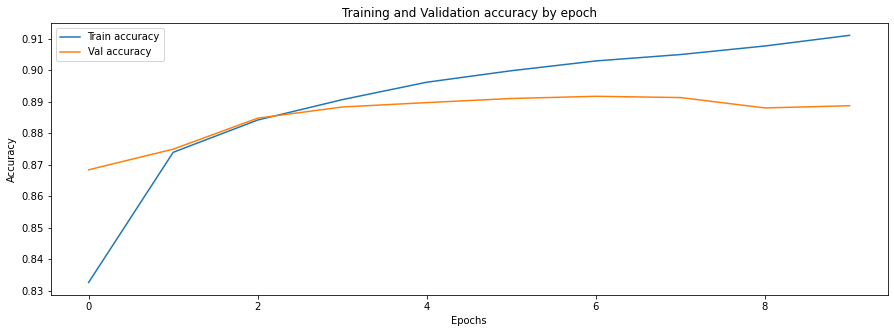

In [17]:
# plot the training history

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title('Training and Validation accuracy by epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy');

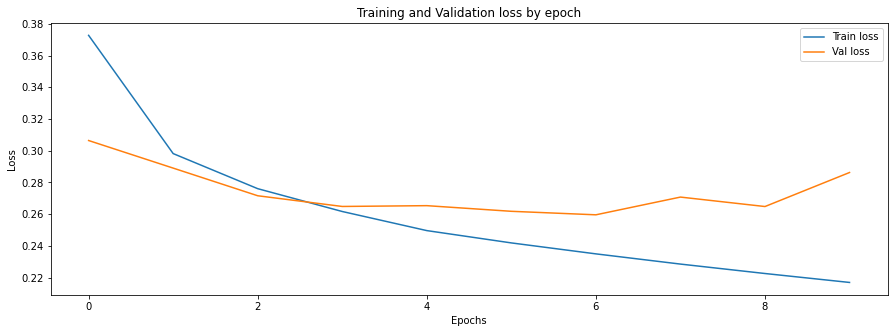

In [18]:
#plot the training history

plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.title('Training and Validation loss by epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss');

We will use epoch 7 since it gives the lowest validation loss and best validation accuracy.

In [18]:
# load weight and compile model
model.load_weights('../savemodels/model-07.hdf5')

adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [16]:
model

In [17]:
# create predicted labels
predictions = (model.predict(val_pad) > 0.5).astype(int)

In [18]:
val_preds = predictions.T[0]

In [19]:
val_preds

array([0, 1, 1, ..., 0, 1, 1])

In [20]:
val_label

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [21]:
# classification report
print(classification_report(val_label, val_preds))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     13297
           1       0.86      0.80      0.83      6703

    accuracy                           0.89     20000
   macro avg       0.88      0.87      0.88     20000
weighted avg       0.89      0.89      0.89     20000



In [22]:
# confusion matrix
cm = confusion_matrix(val_label, val_preds)
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,12444,853
Actual Negative Sentiment,1313,5390


Deep learing outperformed the machine learning classifiers, in terms of accuracy and recall score.

## Model evaluation

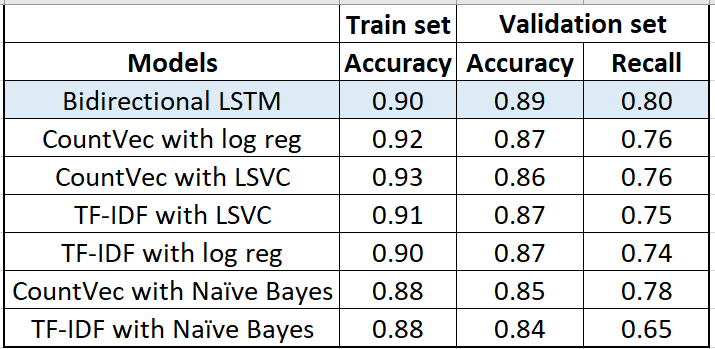

The table above shows the accuracy and recall scores for the different models. Bidirectional LSTM proved to be the best model as it has the highest accuracy and recall scores on validation dataset. With 80% of the time being able to correctly predict on negative reviews, product manager can identify negative sentiment within a large dataset of reviews. Moreover, it beat the baseline model (VADER) as well.

### Predictive words for machine learning

#### Logistic regression

In [12]:
# create a df of words used
coef_lr = pd.DataFrame(gs_cvec_lr.best_estimator_.named_steps['cvec'].get_feature_names(), columns=['tokens'])

# add log reg exp coef
coef_lr['e_coef'] = np.exp(gs_cvec_lr.best_estimator_.named_steps['lr'].coef_)[0]

# find positive and negative words
pos_words_lr = coef_lr.sort_values(by=['e_coef']).head(10)
neg_words_lr = coef_lr.sort_values(by=['e_coef']).tail(10)

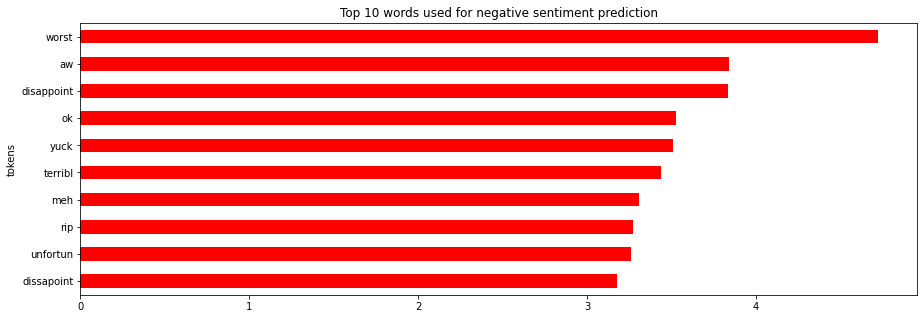

In [13]:
# plot negative words
neg_words_lr.plot.barh('tokens', 
                       'e_coef', 
                       figsize=(15,5), 
                       legend=False, 
                       title='Top 10 words used for negative sentiment prediction', 
                       color='red');

'Worst', 'Aw', 'Disappoint' are top words that are most associated with negative sentiment. The word 'worst' will make negative sentiment more likely than positive sentiment by more than 4 times. Customers probably had a higher expectations for the product that they bought.

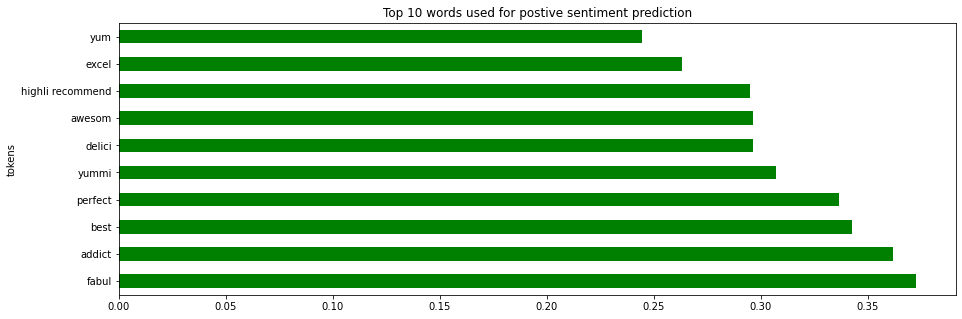

In [14]:
# plot positive words
pos_words_lr.sort_values(by=['e_coef'], ascending=False).plot.barh('tokens', 
                                                                   'e_coef', 
                                                                   figsize=(15,5), 
                                                                   legend=False, 
                                                                   title='Top 10 words used for postive sentiment prediction',
                                                                   color='green');

'Yum', 'Excel', 'Highli recommend' are words associated with positive sentiment. Words that praise the taste of food/product.

#### Linear support vector classifier

In [ ]:
# create a df of words used
coef_lsvc = pd.DataFrame(gs_tvec_lsvc.best_estimator_.named_steps['tvec'].get_feature_names(), columns=['tokens'])

# add log reg exp coef
coef_lsvc['coef'] = gs_tvec_lsvc.best_estimator_.named_steps['lsvc'].coef_[0]

# find positive and negative words
pos_words_lsvc = coef_lsvc.sort_values(by=['coef']).head(10)
neg_words_lsvc = coef_lsvc.sort_values(by=['coef']).tail(10)

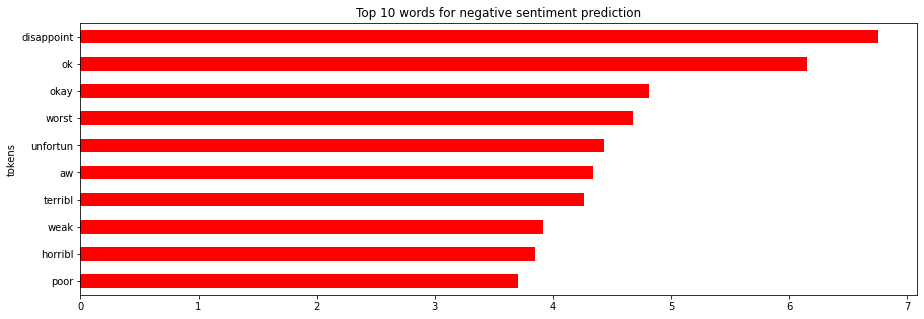

In [ ]:
# plot negative words
neg_words_lsvc.plot.barh('tokens', 'coef', figsize=(15,5), legend=False, title='Top 10 words for negative sentiment prediction', color='red');

Top feature importance for negative sentiment are 'disappoint', 'ok', 'okay'.

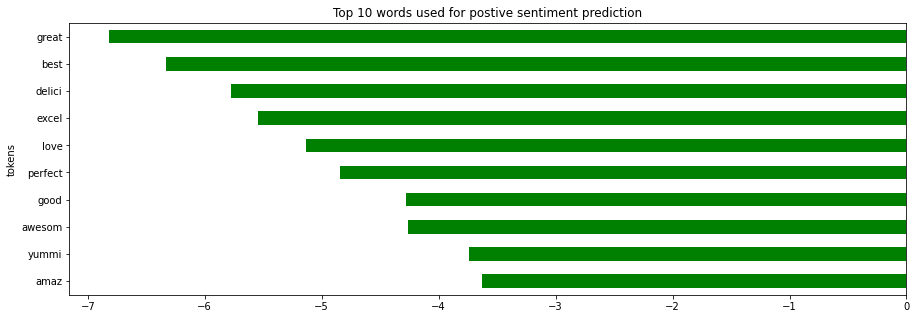

In [ ]:
# plot positive words
pos_words_lsvc.sort_values(by=['coef'], ascending=False).plot.barh('tokens', 
                                                                   'coef', 
                                                                   figsize=(15,5), 
                                                                   legend=False, 
                                                                   title='Top 10 words used for postive sentiment prediction',
                                                                   color='green');

Top feature importance for positive sentiments are 'great', 'best', 'delici'.

### Misclassified reviews for deep learning

We will look at the misclassification on validation set to understand why it predicted wrongly.

In [23]:
# create df to compare actual labels and predicted labels
val = reviews.loc[X1_val.index,:] 
val['pred_label'] = val_preds
val['correct_label'] = (val['pred_label'] == val['label'])

In [24]:
# misclassified reviews
val[val['correct_label']==0].shape

(2166, 4)

In [25]:
# number of false positive
val[(val['label']==0) & (val['pred_label']==1)].shape

(853, 4)

In [26]:
# number of false negative
val[(val['label']==1) & (val['pred_label']==0)].shape

(1313, 4)

In [27]:
# false positive (predicted negative sentiment but actually is positive sentiment)
val[(val['label']==0) & (val['pred_label']==1)].head()

,label,merge_dl,pred_label,correct_label
33914,0,favorite but don t buy them i want them for me these are smoother than red bull and my favorite citrus with a twang dont buy these i want them all for me,1,False
23715,0,peach tea not our favorite length minsour family has tried a number of different types of mio unfortunately the peach tea is definitely not a favorite in our home my daughter actually mixes it with the mio mango peach ounce pack of and prefers that flavor,1,False
63160,0,critter ridder caring control for pets and wildlife about a year ago a female groundhog burrowed underneath my front porch until i did a little online research i didn t know just how annoying and destructive these rodents can be among other names these critters are also called woodchucks and whistle pigs having one of these near your foundation and my basement makes getting rid of them extremely difficult according to online experts the usual extricating methods are putting a water hose down the burrow or pumping carbon dioxide in from the exhaust pipe of your vehicle of course for my situation these methods are neither practical nor safe for the house or the occupants so short of catching her outside the burrow when she happens to be out for a stroll or foraging for a snack what could i do critter ridder manufactured by havahart caring control for pets and wildlife i m not making this up seemed like my only solution the company claims that their product is the selling multi species animal repellent on the market the product i obtained came in a pound jug and according to the label the granules repel skunks groundhogs chipmunks and raccoons further information in the small print on the back indicate this can also be used to discourage domestic pets like dogs and cats from coming into your yard flowerbeds tagging your property and damaging your lawn gardens and other mischief the label also stated that the formula is patented proven technology and sounded like just what i needed it came with an adjustable shaker spout and a comfort grip handle each application is only good for up to days and must be reapplied for maximum effectiveness the instructions are very explicit that gloves must be used when applying the printed red sticker on the label can be seen in the product photo had a curious claim x more than lbs though i didn t expect there would be math involved i soon realized this was a mildly clever but completely unnecessary way of letting prospective customers know that this jug contained times more granules than their pound jug in plain english the seal affirmed that the jug i had contained a full pounds of granules some advertising is just plain unnecessary after filling the hole with as much dirt as it would allow i sprinkled the havahart granules in the opening and around the burrow according to the instructions on the container every good burrow has a backdoor so i did the same with that exit since it is spring almost summer this is a popular time for rodents to emerge from a long winter hibernation and stock up on food i sprinkled the product about a month ago and so far there is no signs of any activity either digging in or out of her burrow aka my home which is a thumbs up for this product so far caution when i opened the box containing the jug of critter ridder i noticed that the lid had a built in pop up spout for pouring out the ingredients the label on the container has the expected number of cautionary statements on concerning hazards to exposed skin eye clothing and domestic animals one thing i also noticed there was no protective seal on the cap and spout also after screwing off the cap in search of a safety seal i noted that there was a seal over the opening of the jug but the seal was broken and some of the contents were missing i doubt that this is the manufacturer s fault i was probably sent a used container from amazon com i will take that up with them and this discovery will not factor in my product rating i do think how

In [31]:
# an example
val.loc[23715]['merge_dl']

'peach tea not our favorite length minsour family has tried a number of different types of mio unfortunately the peach tea is definitely not a favorite in our home my daughter actually mixes it with the mio mango peach ounce pack of and prefers that flavor'

The neural network predicted reviews to be negative when it was actually positive sentiment and they seem even confusing to humans too.

In [28]:
# false negative (predicted positive sentiment but actually is negative sentiment)
val[(val['label']==1) & (val['pred_label']==0)].head()

,label,merge_dl,pred_label,correct_label
58316,1,tiger pops review unfortunately i was hoping to get jumbo tiger pops which are absolutely delicious i have since found out that they may no longer be available in the usa jumbo tp come in four flavors cherry watermelon grape and orange and are round if anyone knows where they can be found please post the answer they are wonderful,0,False
8613,1,kool aid for adults blackberry pomegranate has never let me down before when it comes to flavored drinks when i saw this offering and it claimed to be natural i became very interested from a packaging stand point i love the way these little packets can be thrown in a glove compartment purse diaper bag or book bag they travel well and open easily upon opening the packet i would pour the powder into a standard water bottle fl oz and shake very very vigorously i found that if the water was not ice cold and i did not continue to shake vigorously for a minute then there would be flavor crystal sediment on the bottom if the water was ice cold the powder would incorporate well the color does stain so that may be a concern for some now for the flavor aspect personally this iced green tea mix is just too sweet and artificial flavored from the first sip i was assaulted by a cloyingly sweet and rather sickening flavor i resorted to sort of holding my breath and guzzling down when it came to the last quarter of the bottle i would always dump it just too sweet for me it tasted very much like what i remember red kool aid tasting like when i was young i personally don t allow my children to drink red kool aid they loved this stuff a bit too enthusiastically for my liking they would fight over the bottle which was just plain odd two days passed and when i returned to the cabinet i had discovered that the kids has been sneaking the packets and polished off the whole box my husband on the other hand hated it and he loves sweet drinks he didn t like the sweet fake aftertaste his words if you like very very sweet tasting drinks and prefer when drinks have that fake aspartame taste then this should be a winner for you our kids aged and loved it they found it easy enough to mix on their own apparently i just wish that the product was a bit more natural and less diet recommend only if you fit the the profile of a customer that would enjoy it if you love kool aid mixed with way too many portions then you might just enjoy this kudos on the packaging which is very much like crystal light thumbs down on a very kiddie oriented flavor profile blackberry pomegranate sounds very adult kool aid not so much,0,False
99266,1,delicious but these are really pricey after going to england and then to scotland as well and trying these snacks i was hooked unfortunately they can be difficult to find in the us difficult but not impossible if the price on these drops a bit more i will definitely be picking some up but because the bars are chocolate and can be crushed or melt in transit i don t want to risk spending in the range of dollars to get several packs that have been mis handled and crushed melted the flavor alone for me merits stars but the price drops the rating a bit and keeps me from grabbing these up this very moment,0,False
97698,1,great food horrific price my cat had critically high protein levels in her kidneys prompting my vet to put her on a strict kidney protection program since there are no animal organ transplant operations being done i just couldnt let her suffer luckily this food she actually eats best of all it works her kidney enzimes are back in the normal range thanks to strictly keeping her on this diet unfortunately the price of this food is outrageous for a lb bag c mon that is rediculous i am stuck since she cannot have any other food without deadly consequences i have no cable no phone no cell no movies nothing just to afford this food for her yes it does work but my god get real on the price people i would google other places than here because the se

In [32]:
# an example
val.loc[58316]['merge_dl']

'tiger pops review unfortunately i was hoping to get jumbo tiger pops which are absolutely delicious i have since found out that they may no longer be available in the usa jumbo tp come in four flavors cherry watermelon grape and orange and are round if anyone knows where they can be found please post the answer they are wonderful'

The neural network predicted reviews to be positive when it was actually negative sentiment and humans might not identify them correctly too.

## Test on unseen data

Using the remaining data, apart from the 100,000 that we used as train and test set.

In [3]:
# unseen data, years before 2012 and rating 5 reviews that have been taken out from the start
unseen = pd.read_csv('../datasets/unseen_data.csv')

In [4]:
unseen.shape

(294970, 4)

In [34]:
# unbalanced dataset
unseen['label'].value_counts(normalize=True)

0    0.818053
1    0.181947
Name: label, dtype: float64

In [19]:
unseen_sentence = unseen['merge_dl'].values
unseen_label = unseen['label'].values

In [22]:
unseen_seq = tokenizer.texts_to_sequences(unseen_sentence)
unseen_pad = pad_sequences(unseen_seq, maxlen=max_length)

In [23]:
unseen_pred = (model.predict(unseen_pad) > 0.5).astype(int)

In [24]:
unseen_pred = unseen_pred.T[0]

In [25]:
unseen_pred

array([0, 0, 1, ..., 0, 0, 0])

In [26]:
# classification report
print(classification_report(unseen_label, unseen_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95    241301
           1       0.78      0.79      0.78     53669

    accuracy                           0.92    294970
   macro avg       0.87      0.87      0.87    294970
weighted avg       0.92      0.92      0.92    294970



Even though it was an unbalanced dataset, recall score for negative sentiment is 79% which is quite good, given that only 18% of the dataset was from negative sentiment.

In [27]:
# confusion matrix
cm = confusion_matrix(unseen_label, unseen_pred)
cm_df = pd.DataFrame(
    cm,
    columns = ['Pred Positive Sentiment', 'Pred Negative Sentiment'],
    index=['Actual Positive Sentiment', 'Actual Negative Sentiment']
)
cm_df

,Pred Positive Sentiment,Pred Negative Sentiment
Actual Positive Sentiment,229321,11980
Actual Negative Sentiment,11523,42146


### Misclassifications

In [29]:
# create df to compare actual labels and predicted labels
unseen['pred_label'] = unseen_pred
unseen['correct_label'] = (unseen['pred_label'] == unseen['label'])

In [31]:
# false positive (predicted negative sentiment but actually is positive sentiment)
unseen[(unseen['label']==0) & (unseen['pred_label']==1)].head()

,label,merge_dl,merge,score,pred_label,correct_label
16,0,twizzlers strawberry product received is as advertised twizzlers strawberry ounce bags pack of,"Twizzlers - Strawberry Product received is as advertised.<br /><br /><a href=""http://www.amazon.com/gp/product/B001GVISJM"">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>",5,1,False
34,0,very good but next time i won t order the variety pack i really like the maple and brown sugar flavor the regular is fine with brown sugar added the apples and cinnamon flavor is ok this is a very quick easy and satisfying breakfast and i ll order this brand again but not the variety i ll get all maple and brown sugar,"Very good but next time I won't order the Variety Pack I really like the Maple and Brown Sugar flavor. The regular is fine with brown sugar added. The Apples and Cinnamon flavor is OK. This is a very quick, easy and satisfying breakfast and I'll order this brand again, but not the variety. I'll get all Maple and Brown Sugar.",4,1,False
46,0,pretzel haven this was sooooo deliscious but too bad i ate em too fast and gained pds my fault,pretzel haven! this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault,5,1,False
62,0,taste wise it is a star item the mouth says how do i love thee let me count the ways if you like apple products a must have item the only draw back shipping cost these are very heavy,"Taste wise it is a 6 star item The mouth says, ""How do I love thee, let me count the ways...""<br />If you like apple products a must have item. The only draw back, shipping cost. These are very heavy.",5,1,False
101,0,realemon juice from amazon this is not as good as the frozen lemon juice but it is good it has a slightly odd flavor perhaps from a preservative sure wish i could order the frozen juice,"ReaLemon Juice from Amazon. This is not as good as the Frozen Lemon juice, but it is good. It has a slightly odd flavor, perhaps from a preservative. Sure wish I could order the frozen juice!",4,1,False


In [42]:
unseen.loc[62]['merge']

'Taste wise it is a 6 star item The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.'

Product was good but there was a mix of feelings later about the shipping cost. Also, probably because the number 6 was not fed into the model too.

In [32]:
# false negative (predicted positive sentiment but actually is negative sentiment)
unseen[(unseen['label']==1) & (unseen['pred_label']==0)].head()

,label,merge_dl,merge,score,pred_label,correct_label
42,1,better price for this at target watch your prices with this while the assortment was good and i did get this on a gold box purchase the price for this was less at target,"Better price for this at Target Watch your prices with this. While the assortment was good, and I did get this on a gold box purchase, the price for this was<br />$3-4 less at Target.",3,0,False
45,1,how much would you pay for a bag of chocolate pretzels if you re impulsive like me then is ok don t get me wrong the quality of these babies is very good and i have no complaints but in retrospect the price is a little ridiculous esp when you add on the shipping,"How much would you pay for a bag of chocolate pretzels? If you're impulsive like me, then $6 is ok. Don't get me wrong, the quality of these babies is very good and I have no complaints. But in retrospect, the price is a little ridiculous (esp. when you add on the shipping).",3,0,False
53,1,natural balance lamb and rice while my dogs like all of the flavors that we have tried of this dog food for some reason their itching increased when i tried the lamb and rice i have some very itchy dogs and am giving them a limited ingredient dog food to try to help the duck and sweet potato cut down on the itching significantly but when we tried lamb and rice they started itching more once again i like natural balance for the quality ingredients,"Natural Balance Lamb and Rice While my dogs like all of the flavors that we have tried of this dog food, for some reason their itching increased when I tried the lamb and rice. I have some very itchy dogs and am giving them a limited ingredient dog food to try to help. The duck and sweet potato cut down on the itching significantly, but when we tried lamb and rice they started itching more once again. I like Natural Balance for the quality ingredients.",3,0,False
54,1,increased my dogs itching awesome dog food however when given to my boston who has severe reactions to some food ingredients his itching increased to violent jumping out of bed at night scratching as soon as i changed to a different formula the scratching stopped so glad natural balance has other choices i guess you have to try each until you find what s best for your pet,"INCREASED MY DOGS ITCHING Awesome dog food. However, when given to my ""Boston"", who has severe reactions to some food ingredients; his itching increased to violent jumping out of bed at night, scratching. As soon as I changed to a different formula, the scratching stopped. So glad Natural Balance has other choices. I guess you have to try each, until you find what's best for your pet.",3,0,False
120,1,these just don t do it for me as breath mints to me these are nothing like the regular altoids and are not breath mints they are pleasant tasting little candies in a cute convenient tin and that s as far as it goes the mintiness is just not strong and the wintergreens are definitely weaker than the peppermint minis i m not a dragon breath person but still one of these mints is too small to have any effect on my breath four or five will freshen my breath for a short while maybe minutes at this point i think the icebreakers frost mints are the best as sugar free breath mints,"These just don't do it for me as breath mints To me, these are nothing like the regular Altoids and are not breath mints. They are pleasant-tasting little candies in a cute convenient tin, and that's as far as it goes. The mintiness is just not strong, and the wintergreens are definitely weaker than the peppermint minis. I'm not a dragon-breath person, but still, one of these mints is too small to have any effect on my breath. Four or five will freshen my breath for a short while - maybe 15 minutes. At this point, I think the Icebreakers Frost mints are the best as sugar free breath mints.",1,0,False


In [37]:
# an example
unseen.loc[45]['merge']

"How much would you pay for a bag of chocolate pretzels? If you're impulsive like me, then $6 is ok. Don't get me wrong, the quality of these babies is very good and I have no complaints. But in retrospect, the price is a little ridiculous (esp. when you add on the shipping)."

The quality of product is great but the price caused rating to be bad.

## Topic modeling

Using Gensim's Latent Dirichlet Allocation (LDA) to identify the key topics that customers are facing.

Before running LDA, we will first perform a simple pre-processing, tokenizing, removing stopwords, lemmatizing and keep tokens that are nouns, adjectives, verbs or adverbs for better topics output.

Reference:
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

### Negative Sentiment

In [5]:
# negative sentiment reviews
docs = list(reviews.loc[reviews['label']==1]['merge_dl'].values)

# first negative review
docs[:1]

['not as advertised product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo']

##### Tokenize

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

In [7]:
words = list(sent_to_words(docs))

In [8]:
print(words[:1])

[['not', 'as', 'advertised', 'product', 'arrived', 'labeled', 'as', 'jumbo', 'salted', 'peanuts', 'the', 'peanuts', 'were', 'actually', 'small', 'sized', 'unsalted', 'not', 'sure', 'if', 'this', 'was', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intended', 'to', 'represent', 'the', 'product', 'as', 'jumbo']]


##### Remove stopwords

In [9]:
sw = stopwords.words('english')
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in sw] for doc in texts]

In [11]:
words = remove_stopwords(words)
print(words[:1])

[['advertised', 'product', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'peanuts', 'actually', 'small', 'sized', 'unsalted', 'sure', 'error', 'vendor', 'intended', 'represent', 'product', 'jumbo']]


##### Lemmatize

To root form of word and only keep tokens that are nouns, adjectives, verbs or adverbs to get better key topics

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, postag=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in postag])
    return texts_out

In [13]:
lem_words = lemmatization(words)

In [14]:
print(lem_words[:1])

[['advertise', 'product', 'arrive', 'label', 'salt', 'peanut', 'peanut', 'actually', 'small', 'sized', 'unsalted', 'sure', 'error', 'vendor', 'intend', 'represent', 'product', 'jumbo']]


##### Creating a BoW Corpus

In Gensim, the corpus contains the word id and its frequency in every document.

In [15]:
# create dictionary and corpus for topic modeling, a mapping between words and their integer ids.
id2word = Dictionary(lem_words)

In [16]:
print(id2word)

Dictionary(24507 unique tokens: ['actually', 'advertise', 'arrive', 'error', 'intend']...)


In [17]:
# convert document (a list of words) into the bag-of-words format -> list of (token_id, token_count) 2-tuples.
corpus = [id2word.doc2bow(text) for text in lem_words]

In [31]:
# build lda model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=6, 
                                            random_state=40,
                                            update_every=1, # model params updated
                                            chunksize=100, # no. of docs to consider at once
                                            passes=10, # times algo pass over whole corpus
                                            per_word_topics=True) # extract most likely topics given a word

In [32]:
# 6 topics
for i in lda_model.print_topics():
    print(i)
    print('\n')

(0, '0.066*"tea" + 0.057*"coffee" + 0.039*"flavor" + 0.022*"taste" + 0.020*"cup" + 0.019*"strong" + 0.017*"good" + 0.015*"bean" + 0.014*"bag" + 0.012*"drink"')


(1, '0.051*"taste" + 0.025*"water" + 0.019*"try" + 0.018*"drink" + 0.018*"bad" + 0.016*"bottle" + 0.012*"smell" + 0.012*"would" + 0.011*"squeeze" + 0.011*"really"')


(2, '0.051*"oil" + 0.047*"product" + 0.044*"ingredient" + 0.023*"natural" + 0.022*"contain" + 0.021*"list" + 0.021*"food" + 0.014*"make" + 0.014*"corn" + 0.013*"weak"')


(3, '0.022*"use" + 0.017*"hair" + 0.017*"product" + 0.013*"price" + 0.013*"good" + 0.011*"buy" + 0.011*"food" + 0.010*"make" + 0.010*"well" + 0.010*"go"')


(4, '0.032*"taste" + 0.025*"cookie" + 0.024*"vitamin" + 0.023*"flavor" + 0.019*"good" + 0.018*"chocolate" + 0.018*"sugar" + 0.014*"eat" + 0.012*"fruit" + 0.012*"much"')


(5, '0.026*"order" + 0.025*"product" + 0.022*"bag" + 0.020*"dog" + 0.014*"box" + 0.014*"package" + 0.013*"receive" + 0.013*"get" + 0.013*"buy" + 0.013*"item"')




#### Each document is composed of multiple topics. We will find the dominant topic for each sentence below.

In [33]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Initialise output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lem_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.3879,"oil, product, ingredient, natural, contain, list, food, make, corn, weak","[advertise, product, arrive, label, salt, peanut, peanut, actually, small, sized, unsalted, sure, error, vendor, intend, represent, product, jumbo]"
1,1,3.0,0.9489,"use, hair, product, price, good, buy, food, make, well, go","[cat, fan, new, food, cat, happily, eat, felidae, platinum, year, get, new, bag, shape, food, different, try, new, food, first, put, bowl, bowl, sit, full, kitty, touch, food, notice, similar, review, relate, formula, change, unfortunately, need, find, new, food, cat, eat]"
2,2,1.0,0.5425,"taste, water, try, drink, bad, bottle, smell, would, squeeze, really","[poor, taste, love, eat, good, watch, tv, look, movie, sweet, transfer, lock, baggie, stay, fresh, take, time, eat]"
3,3,3.0,0.5564,"use, hair, product, price, good, buy, food, make, well, go","[plan, would, never, buy]"
4,4,1.0,0.4931,"taste, water, try, drink, bad, bottle, smell, would, squeeze, really","[stuff, stuff, buy, store, healthy, sugar, save, money, get, least, taste]"
5,5,1.0,0.9232,"taste, water, try, drink, bad, bottle, smell, would, squeeze, really","[purchase, flavor, take, sweetness, unfortunately, hint, aftertaste, almost, licorice, consume, various, sport, nutrition, product, decade, familiar, come, taste, product, try, least, appeal, taste, terrible, bad, enough, notice, bad, taste, sip, take]"
6,6,3.0,0.3391,"use, hair, product, price, good, buy, food, make, well, go","[warn, warn, alcohol, buyer, beware, sweeten, sugar, undigestible, body, know, short, time, consume, unsuspecte, many, can, digest, extreme, intestinal, bloating, cramp, massive, amount, gas, person, experience, also, experience, learn, lesson, hard, way, year, ago, fall, love, sugar, chocolate, sommer, use, sell, thought, find, sugar, first, short, live, terrible, side, effect, kick, discomfort, ever, feel, blew, balloon, painful, abdominal, cramping, symptom, pass, unpleasant, believe, low..."
7,7,0.0,0.7093,"tea, coffee, flavor, taste, cup, strong, good, bean, bag, drink","[order, cold, weather, taste, great, berry, melt, may, order, winter, order, cold, weather, enjoy, flavor]"
8,8,1.0,0.6357,"taste, water, try, drink, bad, bottle, smell, would, squeeze, really","[bad, hate, eat, give, terrible, diarrhea, buying, also, super, expensive]"
9,9,3.0,0.4645,"use, hair, product, price, good, buy, food, make, well, go","[love, raman, reason, thing, burn, stomach, badly, burn, sensation, go, away, hour, sure, healthy, buy, cheap]"


#### The most representative sentence for each topic

In [34]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 500

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9635,"tea, coffee, flavor, taste, cup, strong, good, bean, bag, drink","[tea, tea, strong, taste, spearmint, mint, expect, think, would, well, less, intense, would, make, second, cup, drink, may, ok, order, prefer, mint]"
1,1.0,0.9679,"taste, water, try, drink, bad, bottle, smell, would, squeeze, really","[water, coconut, taste, highly, diluted, coconut, water, taste, taste, coconut, water, water, finally, naked, water, coconut, water, stay, away, way, taste, coconut, water, go, good]"
2,2.0,0.8955,"oil, product, ingredient, natural, contain, list, food, make, corn, weak","[contain, ingredient, list, see, ingredient, list, see]"
3,3.0,0.9651,"use, hair, product, price, good, buy, food, make, well, go","[double, price, double, price, sale, exact, product, greedy, people, go, could, almost, buy, year, membership, extra, price, charge, people, probably, buy, charge, double]"
4,4.0,0.9535,"taste, cookie, vitamin, flavor, good, chocolate, sugar, eat, fruit, much","[low, sodium, option, well, extremely, good, vitamin, taste, bit, low, sodium, option, well, almost, taste, much, healthy]"
5,5.0,0.9601,"order, product, bag, dog, box, package, receive, get, buy, item","[outdated, order, pack, sell, date, exactly, month, day, receive, probably, would, purchase, know, prior, purchase, bone, racid, little, disappointing, know, could]"


#### Using pyLDAVis to visualise

In [35]:
# set better display
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\piggy\anaconda3\envs\nlpdsi\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.030372 -0.091807       1        1  30.195925
1      0.095511 -0.058313       2        1  19.597691
5     -0.016297 -0.271717       3        1  18.260937
4      0.138367  0.189216       4        1  13.850293
0      0.162498  0.127809       5        1  10.594267
2     -0.410451  0.104812       6        1   7.500888, topic_info=        Term          Freq         Total Category  logprob  loglift
512      tea   9292.000000   9292.000000  Default  30.0000  30.0000
57     taste  22371.000000  22371.000000  Default  29.0000  29.0000
316   coffee   8000.000000   8000.000000  Default  28.0000  28.0000
8    product  19865.000000  19865.000000  Default  27.0000  27.0000
82    flavor  12260.000000  12260.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
439  include    550.997120   1146.207238   Topic6  -5.1977   1.8577
95      also    634.708258   4800.281376   Topic6  -5.0563   0.5669
478    color    550.854615   1660.687378   Topic6  -5.1980   1.4866
179      use    617.257487  13211.615584   Topic6  -5.0841  -0.4734
379      say    567.884739   6541.594488   Topic6  -5.1675   0.1461

[349 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
345       2  0.510849       add
345       4  0.407226       add
345       5  0.044306       add
345       6  0.037527       add
1103      6  0.996721  additive
...     ...       ...       ...
65        5  0.100083     would
313       3  0.999100      wrap
45        1  0.709449      year
45        3  0.269538      year
45        5  0.020969      year

[478 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 6, 5, 1, 3])

#### WordClouds

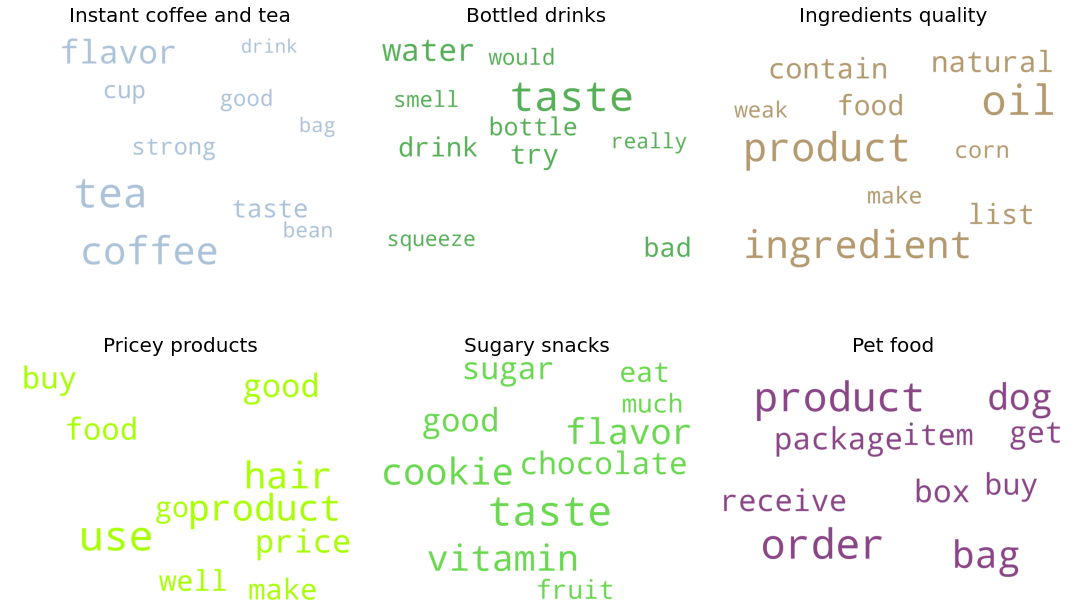

In [44]:
# 1. Wordcloud of Top N words in each topic

cols = [color for name, color in mcolors.XKCD_COLORS.items()] 

cloud = WordCloud(stopwords=sw,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(15,10), sharex=True, sharey=True)

topic = ['Instant coffee and tea', 'Bottled drinks', 'Ingredients quality', 'Pricey products', 'Sugary snacks', 'Pet food']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic[i], fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Recommendations and conclusions

The model that performed the best was Bidirectional LSTM, consisting of 3 layer neural network - Bidirectional LSTM with 50 nodes, followed by a dense layer with 10 nodes and then an output layer with 1 node. With an accuracy of 0.89 and recall of 0.83 on validation set, the model serves as a good start for group the reviews into positive or negative sentiment and understand customers' preferences. Furthermore, on unseen data, with an even more unbalanced dataset, the model did well on the minority class, with a recall score of 0.79

We can further improve the neural network by tuning it further using keras tuner or trying out with other layers.

We realised that when using a bigger dataset, neural network outperformed classical machine learning models. While on a smaller dataset, classical machine learning models outperformed neural network.

Misclassification occurs when there are a mix of polarity in a review, at one point indicating it was good and another point indicating it as bad or in a particular review, customers may be talking about different things, with some good and some bad.

Topics that customers were dissatisfied about - Instant coffee and tea, bottled drinks, ingredient quality, pricey products, sugary snacks and pet food. Manufacturers could focus on improving their products, focuses on qualities that customers are concerned about and offering discounts to low quality products.

Further enhancement to this project can be made, we can do further in-depth analysis in topic modeling and further tuning of the neural network.